In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
LAG = 12
EPS = 60
SIND = 30
HSIZE = 256
STOPS = 5
DEEP = False
SROUTE = SAMPLE_ROUTES[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
dset = SingleStop(
    SROUTE, SIND, 'train', 32, 
    lag=LAG, stops=STOPS).generator()
evalset = SingleStop(
    SROUTE, SIND, 'test', 32, 
    lag=LAG, stops=STOPS).generator(shuffle=False)

Locals dataset: train (metadata/2h/M102_0.json)
 [*] Loaded routes: 1 (0.08s)
 [*] Has trainable inds: 109128
 [*] Subset train: 88215
 [*] Subset in Stop-30: 2129
Locals dataset: test (metadata/2h/M102_0.json)
 [*] Loaded routes: 1 (0.08s)
 [*] Has trainable inds: 109128
 [*] Subset test: 20913
 [*] Subset in Stop-30: 540


In [5]:
from models.temporal.RNN import RNN

In [6]:
if not DEEP:
    model = RNN(hidden_size=HSIZE, steps=STOPS).to(device)
else:
    model = RNN(hidden_size=HSIZE, steps=STOPS).to(device)
model.device = device

In [7]:
criterion, opt, sch = model.params(lr=0.001)

In [8]:
# Xs, Ys are reversed, so last (-1) holds the first SOI (stop of interest)
mseop = lambda _y, y: criterion(_y[:, :, -1], y[:, :, -1])
evaluate(evalset, model, crit=lambda _y, y: np.sqrt(mseop(_y, y).item()))
evaluate(evalset, model, crit=lambda _y, y: mseop(_y, y).item())

Eval loss: 4.3721   
Eval loss: 19.4025   


In [9]:
losses = []
eval_mse = []
eval_mape = []
from numpy.random import randint
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            loss.item()
        ))
    sys.stdout.write('\n')

    eval_mse.append(
        evaluate(evalset, model, crit=lambda _y, y: mseop(_y, y).item(), result=True))
    sys.stdout.flush()
#     sch.step()

[1/60 : 66/66] - L3.91       
Eval loss: 5.2904    
[2/60 : 66/66] - L2.34      
Eval loss: 4.4551   
[3/60 : 66/66] - L4.21      
Eval loss: 4.3130   
[4/60 : 66/66] - L3.05      
Eval loss: 4.1712   
[5/60 : 66/66] - L2.27      
Eval loss: 4.0407   
[6/60 : 66/66] - L1.65      
Eval loss: 3.9152   
[7/60 : 66/66] - L2.83      
Eval loss: 3.7989   
[8/60 : 66/66] - L2.28      
Eval loss: 3.6997   
[9/60 : 66/66] - L1.97      
Eval loss: 3.6142   
[10/60 : 66/66] - L3.23      
Eval loss: 3.5381   
[11/60 : 66/66] - L1.84      
Eval loss: 3.4775   
[12/60 : 66/66] - L2.16      
Eval loss: 3.4241   
[13/60 : 66/66] - L1.84      
Eval loss: 3.3876   
[14/60 : 66/66] - L1.69      
Eval loss: 3.3279   
[15/60 : 66/66] - L3.23      
Eval loss: 3.2921   
[16/60 : 66/66] - L1.67      
Eval loss: 3.2629   
[17/60 : 66/66] - L2.04      
Eval loss: 3.2345   
[18/60 : 66/66] - L4.97      
Eval loss: 3.2001   
[19/60 : 66/66] - L2.70      
Eval loss: 3.1661   
[20/60 : 66/66] - L2.43      
Eval los

In [10]:
VIEW_LAG=96
viewset = SingleStop(
    SROUTE, SIND, 'test', 32, 
    lag=VIEW_LAG, stops=5)
viewset = [viewset[ii] for ii in range(1)]

Locals dataset: test (metadata/16h/M102_0.json)
 [*] Loaded routes: 1 (0.00s)
 [*] Has trainable inds: 262
 [*] Subset test: 59
 [*] Subset in Stop-30: 1


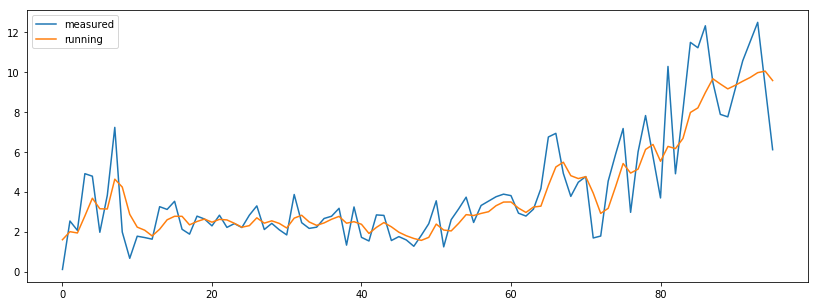

In [19]:
from utils import *
# Dense
# STOPS = 1
model.lag = 5
show_eval_rnn(viewset, model)
# torch.save(model.state_dict(), 'checkpoints/dense_n1.pth')